## Working with core photographs

We're going to work with core photos. We have a couple of examples:

In [2]:
ls data/core_photos/

P-129_1588.2-1590.1.jpg*           P-129_Flattened_1588.2-1590.1.png
P-129_1588.2-1590.1.png            P-129_Flattened_1588.2-1590.1.svg


Let's set up our go-to well with some curves and a striplog:

In [3]:
from welly import Well
w = Well.from_las('data/las/P-129_out.LAS')

from striplog import Striplog, Legend
l = Legend.builtin('NSDOE')
s = Striplog.from_image('data/images/P-129_280_1935.png', legend=l, start=280, stop=1935)

w.data['strip'] = s
w

We'll use a core photo:

In [4]:
c = 'data/core_photos/P-129_1588.2-1590.1.jpg'

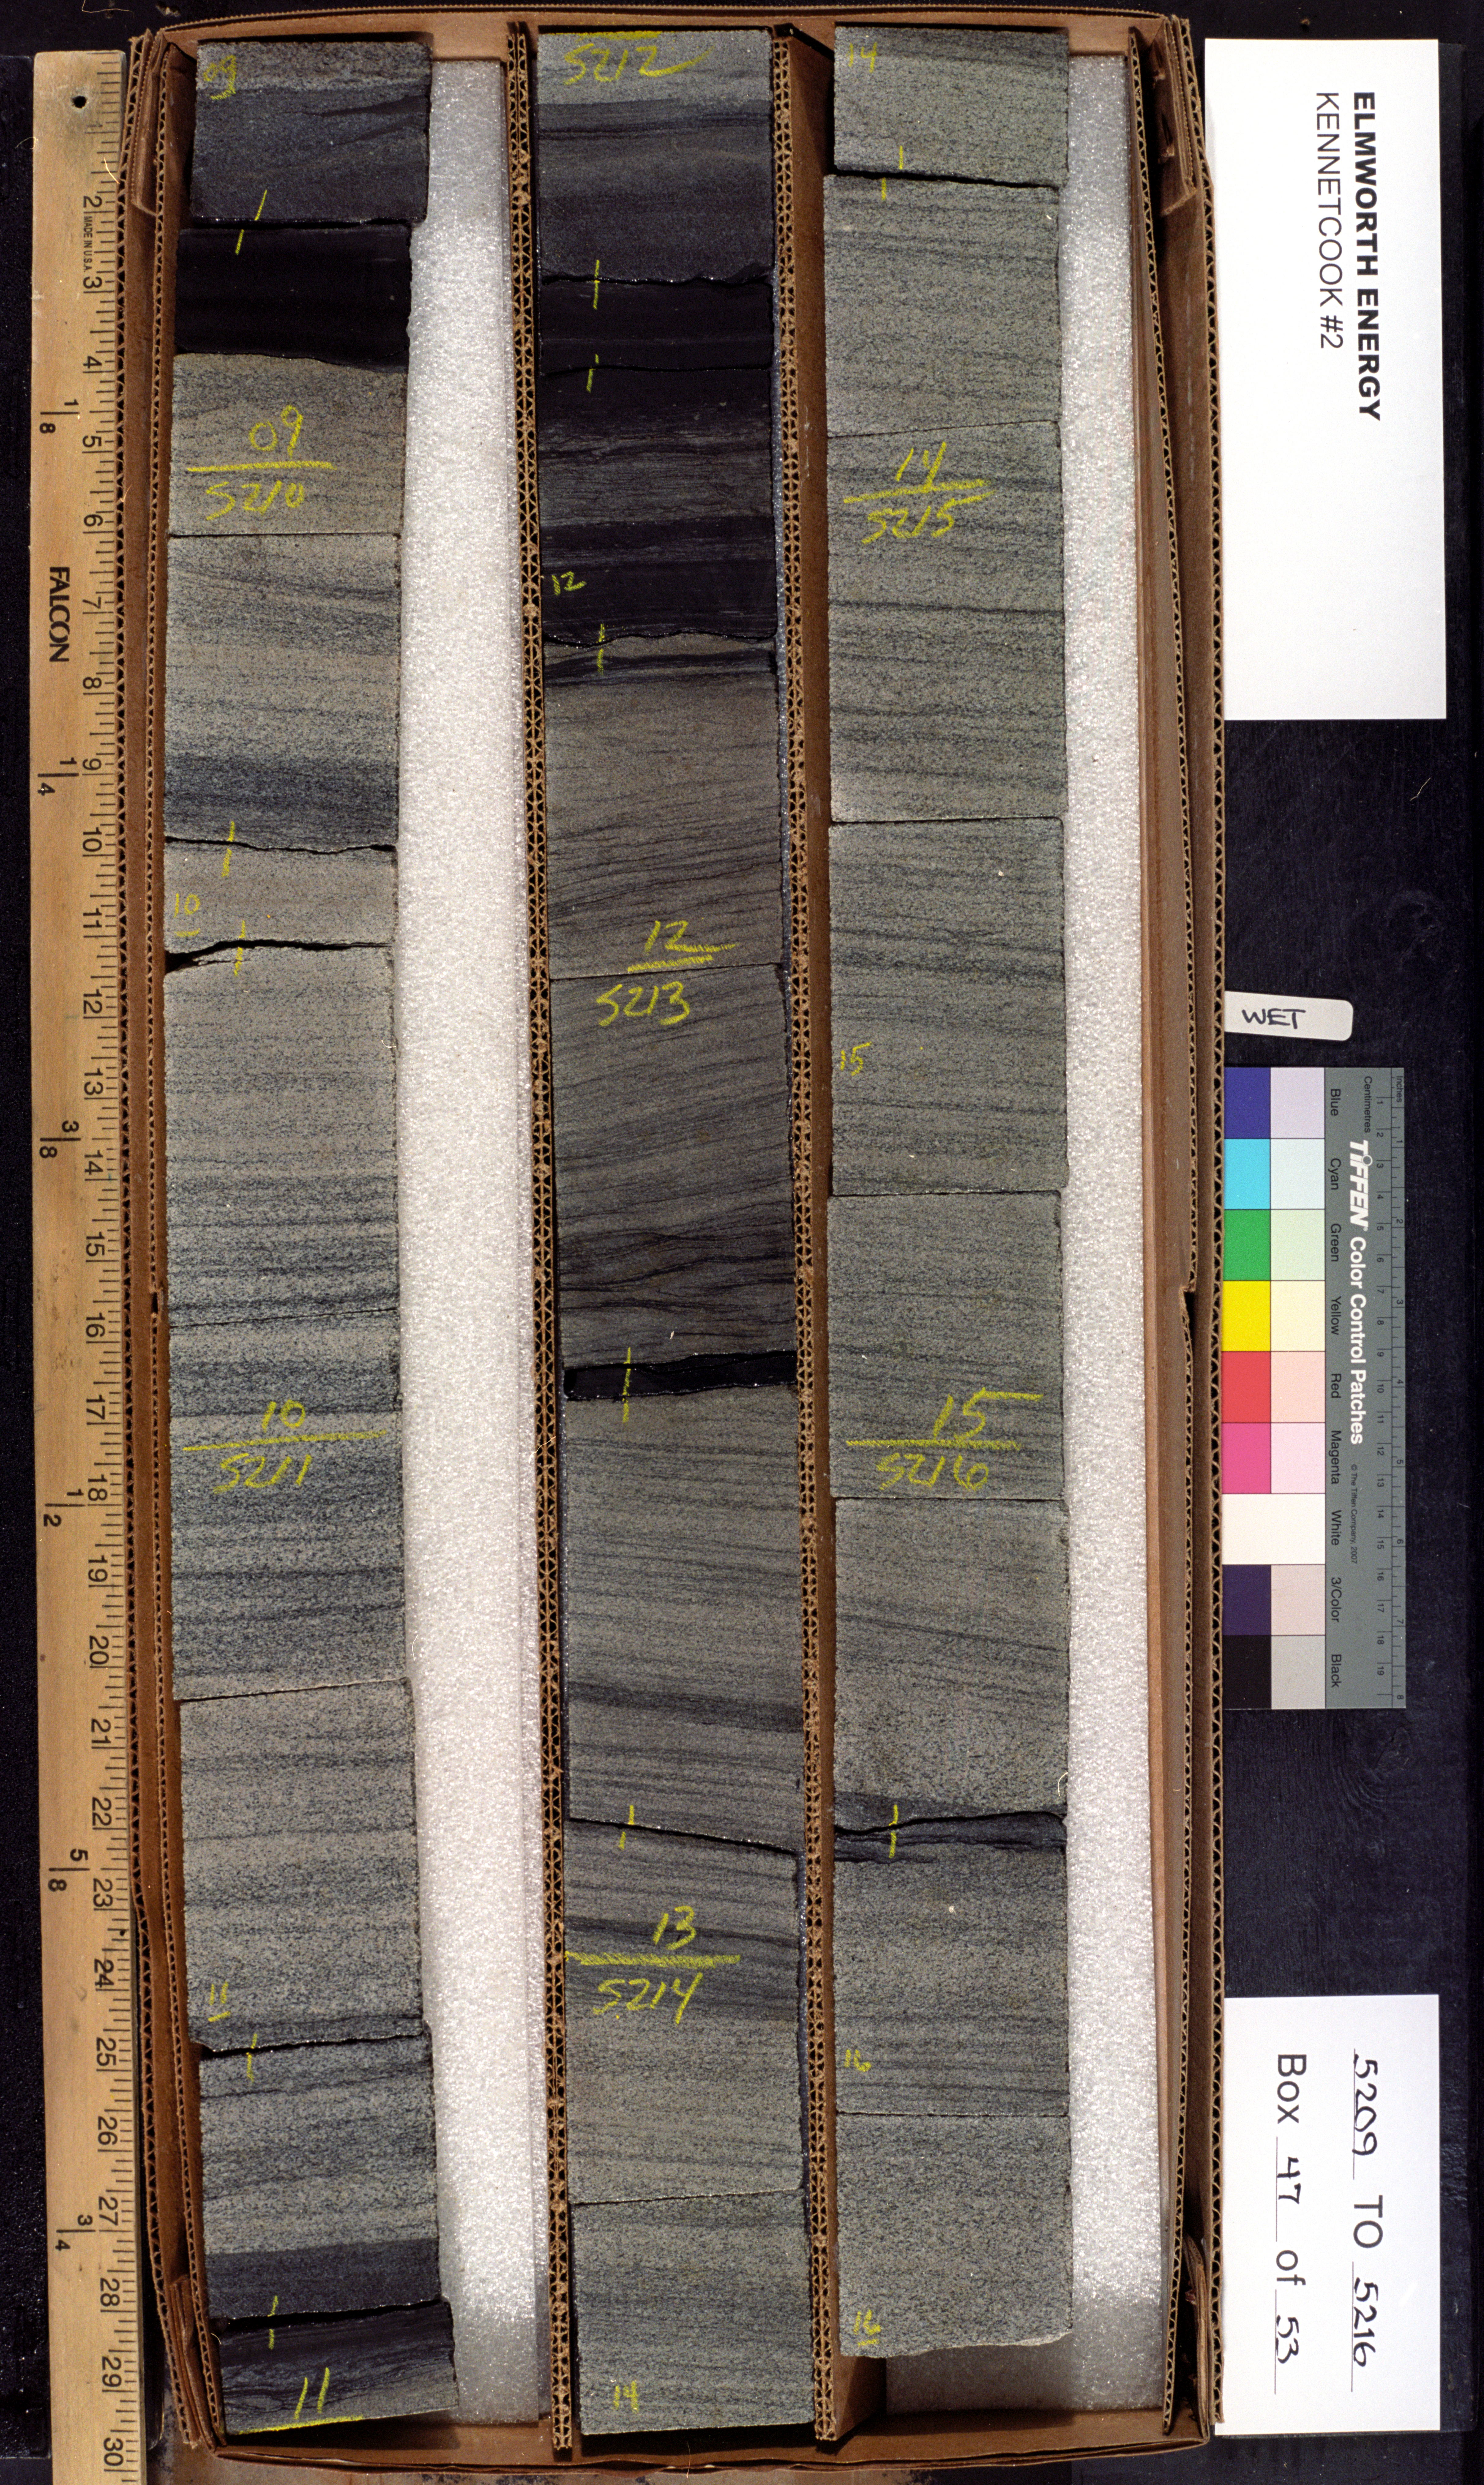

In [5]:
from IPython.display import Image
Image(c, width=250)

We can add it to the striplog, which is part of the well object's dictionary of data. 

In [46]:
s.read_at(1589).data['photo'] = c

In [47]:
w.data['strip'].read_at(1589)

Interval({'data': {'photo': 'data/core_photos/P-129_1588.2-1590.1.jpg'}, 'description': '', 'base': Position({'middle': 1600.1043878725854, 'units': 'm'}), 'components': [Component({'grainsize': 'f-m', 'lithology': 'sandstone', 'colour': 'grey'})], 'top': Position({'middle': 1573.0891646411667, 'units': 'm'})})

Really, the thing to do is probably to make a striplog especially for the core photo(s):

In [16]:
from striplog import Interval
p = Striplog([Interval(top=1588.2, base=1590.1, data={'photo': c})])

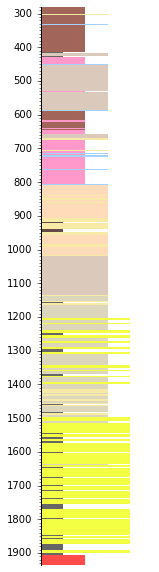

In [36]:
fig = plt.figure(figsize=(2,10))
ax = fig.add_subplot(111)
ax = s.plot(ax=ax, legend=l)
plt.show()

In [28]:
ax

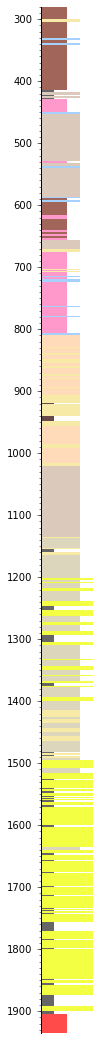

In [26]:
s.plot(l)

# A little digression into Matplolib options

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
from matplotlib.transforms import Bbox, TransformedBbox, \
    blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
    BboxConnectorPatch


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p


In [91]:
def plot_core(self, fig, image_field):
    """
    returns a figure of a corephoto with zoom in effect in an additional 
    track to the right of a regular track
    uses zoom_effect01 in photo_axes_zoom_effect.py
    
    Args:
        image_field (str): the name of the field containing the image paths.
    
    Returns:
        fig: the matplotlib figure you passed in.
    """
    mx, my, tw, th = 0.0, 0.1, 0.25, 0.8
    mainax = fig.add_axes([mx, my, tw, th])
    mainax = s.plot(ax=mainax, legend=l)

    ylim = mainax.get_ylim()
    
    for iv in self:

        im_path = iv.data.get(image_field)

        # Skip intervals without an image
        if im_path is None:
            continue
            
        im = mpl.image.imread(im_path)

        print([mx, my, tw, th])
        print(ylim, iv)
        print([0.4, my, 0.5, th])
        
        top = (ylim[1] - iv.top.z) / (ylim[1] - ylim[0])
        imgh = abs((iv.thickness) / (ylim[1] - ylim[0]))
        base = top - imgh

        zoom = 20

        print([0.4, my+(base-zoom*imgh/2)*th, 0.5, (zoom*imgh)*th])
        
        fakeax = fig.add_axes([0.4, my, 0.5, th])
        zoomax = fig.add_axes([0.4, my+(base-zoom*imgh/2)*th, 0.5, (zoom*imgh)*th])

        zoomax.set_xlim(0, im.shape[1]) # these number of x-pixels of the core photo
        zoomax.set_ylim(0, im.shape[0]) # these number of y-pixels of the core photo

        c1, c2, bbox_patch1, bbox_patch2, p = zoom_effect01(mainax, zoomax, xmin=0, xmax=1, )

        mainax.add_patch(bbox_patch1)
        zoomax.add_patch(bbox_patch2)
        zoomax.add_patch(c1)
        zoomax.add_patch(c2)
        zoomax.add_patch(p)

        zoomax.imshow(im)
        zoomax.axis('off')
        fakeax.axis('off')

    return

[0.0, 0.1, 0.25, 0.8]
(1935.0, 280.0) {'data': {'photo': 'data/core_photos/P-129_1588.2-1590.1.jpg'}, 'description': '', 'base': Position({'middle': 1600.1043878725854, 'units': 'm'}), 'components': [Component({'grainsize': 'f-m', 'lithology': 'sandstone', 'colour': 'grey'})], 'top': Position({'middle': 1573.0891646411667, 'units': 'm'})}
[0.4, 0.1, 0.5, 0.8]
[0.4, 0.58141230651144915, 0.5, 0.26117436356658619]


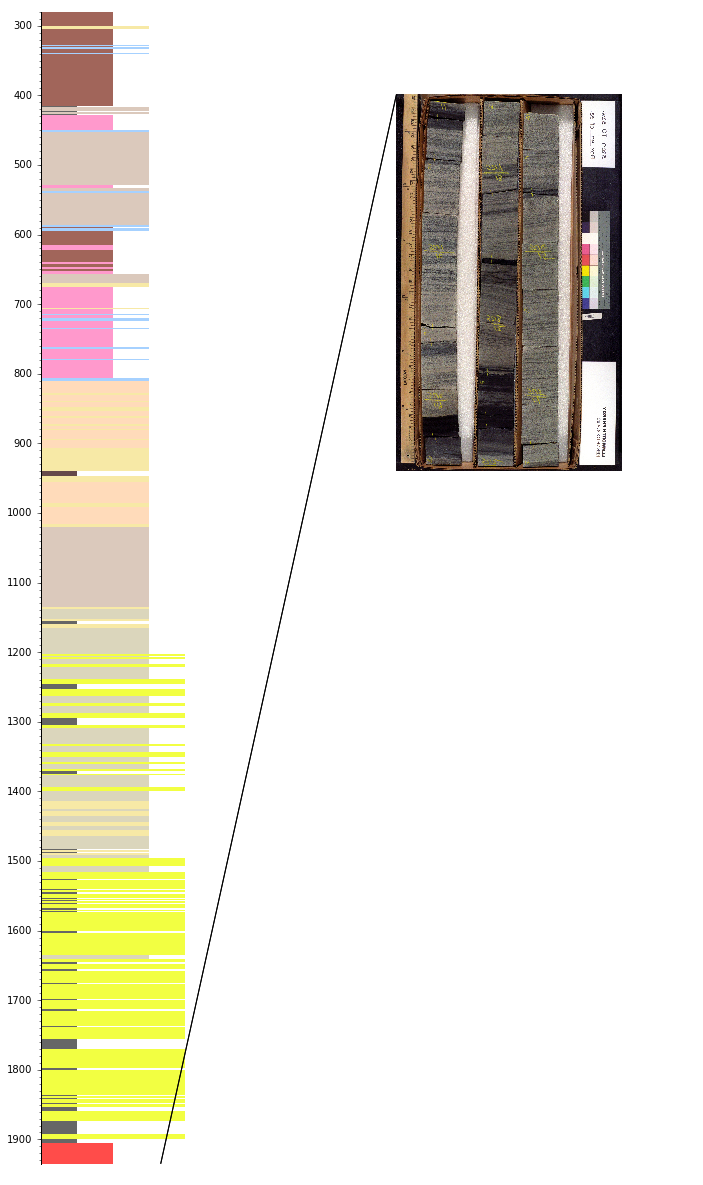

In [92]:
fig = plt.figure(figsize=(10,20))
plot_core(s, fig, 'photo')
plt.show()